In [48]:
import numpy as np
import matplotlib.pyplot as plt
import hmms
from pprint import pformat

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [149]:
# My experiment for prediction of emmission states within STATE 4
#(as state4 consists of several node transition in a unidirectional way): 

# NOTE : State 4 is as same as that of state 0 in a way that if state 4 do transition among node it means the state will 
         #be chnage to some other state ( more likely it will be called state 0 / state 3). Hence in state 4 , picker will
         # spend his whole time in a perticular node ( most likely node is headnode) . 

#STEP 1: Create a model of sequences with prior known(randomly generated) transition matrix, 
        # emmision probability, and initial state prob.vector 

# We are considering 2 ROWS (96nodes + 2 pri-hn-XX + sec-hn-XX). NOT considering COLD STORAGE node. 
# HOW TOPO_MAP LOOKS like :  ---><pri-hn-00 ---><--- 1---><---2.... --><--96 ---><---sec-hn-00---><---sec-hn-01.... 
#  ---><--- rn-01-01---><---rn-01-00 ---><---pri-hn-01---><pri-hn-00. This topo_map can be considered as CIRCLE 
# with 200 nodes in it based on the connections it has got between nodes hence the TOPO_MAP matrix would be 200 X 200
# OR (to make life lil hectic) we can consider 2 ROWS case with 96 nodes in it hence the TOPO_MAP matrix would be 200 X 98, (96+2=98) 

# LETS do THE hectic WAY: We are considering 2 ROWS topo_map (matrix would be 200 X 98) 
N_nodes = 100 #10    

# expected mean rate in seconds
_rate = 0.009  #0.09
_lambda = 1.0/_rate    # Need to fix lambda for state 3

#----(Based on DES data):NOTE: for STATE4: Althoght the picker is gonna stay in pri-hn-00 node but for keeping - 
#  -it lil real, we can give small likelihood to the case where picker can make trabsition between nodes as
#  (pri-hn-00 -><-- 1 -><- 2).

#topo_map=np.eye(N_nodes, k=1)   # for forward transition 
#topo_map[-1,0] = 1              # make a full circle in forward direction in topomap  
#print ('topo_map:', topo_map)

#topo_map+=np.eye(N_nodes, k=-1) # for backward transition            
#topo_map[0,-1] = 1              # make a full circle in reverese direction
#print (topo_map)

#------------------------------------------------#####------------------------------------------------#
# TRY 2: Create 200 X 100 matrix 

topo_map1 = np.eye(N_nodes, k=1)
topo_map1[-1,0] = 1

topo_map1 += np.eye(N_nodes, k=-1)*0.5
print ('T1:', topo_map1)


topo_map2 = np.eye(N_nodes, k=1)*0.5

topo_map2 += np.eye(N_nodes, k=-1)*1
print ('T2:', topo_map2)

topo_map = np.concatenate((topo_map1, topo_map2))
print ('topo_map:', np.size(topo_map))


# summing all column of adjency matrix
rs = np.sum(topo_map,1)       # it sums up all the columns of a single row, 
#print ('rs:', rs)             #so that it can help in defining Q in next step

# creating the transition rate matrix (https://en.wikipedia.org/wiki/Transition_rate_matrix)
Q = (np.diag(-rs[:100]) + topo_map[:100]) * _lambda   # Keep in mind that, sum(Qij) = -Qii < 1. 
print ('Q1:', Q)

Q += (np.diag(-rs[100:200]) + topo_map[100:200]) * _lambda
print ('Q2:', Q)

# FOR ANY OF THE STATES , VALUE OF 'B' IS NOT TOUCHED KEEPING THE ASSUMPTION OF MARC AS REF.


# # NOTE: for each STATE , the value of B is taken from observed values in DES for STATE 4: There is high 
# likelihood that picker will not transit among nodes (like pri-hn-00-pri-hn-00). 

# Creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# and another ~10% for neighbouring states each (confusing them). and +.1% for all observations for numerical stability  
B_pre = np.ones(N_nodes) * .001 + np.eye(N_nodes) * .7 + np.eye(N_nodes, k=1) * .05 + np.eye(N_nodes, k=-1) * .05

# adding 10% change of "unknown" observation which each state is equally likely to emit (used for prediction)
# This assumption can be eliminated 
B = np.transpose(np.vstack([B_pre, [.101] * N_nodes]))  # np.vstack will add extra column in B_pre matrix vertically
B[0,-2] = .101     # first row and second last column is filled with 0.101
B[-1,0] = .101     # Last row and first columm is filled with 0.101


# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]


# Pi is the vector of initial state probabilities. Assuming uniform here
# (We may make a stronger assumption here at some point)
Pi = np.array( [1.0 / N_nodes] * N_nodes )

# Create CtHMM by given parameters.
chmm = hmms.CtHMM(Q,B,Pi)
print('Q=%s,\nB=%s,\nPi=%s' % chmm.params)
chmm.save_params("state2_cthmm")
chmm_from_file = hmms.CtHMM.from_file( "state2_cthmm.npz" )

#Set & Get Parameters:Later you can always set parameters with triple of methods corresponding to the constructors.
# chmm.set_params(Q,B,Pi)
# chmm.set_params_random(3,3)
# chmm.set_params_from_file( "state2_cthmm.npz" )

T1: [[0.  1.  0.  ... 0.  0.  0. ]
 [0.5 0.  1.  ... 0.  0.  0. ]
 [0.  0.5 0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  1.  0. ]
 [0.  0.  0.  ... 0.5 0.  1. ]
 [1.  0.  0.  ... 0.  0.5 0. ]]
T2: [[0.  0.5 0.  ... 0.  0.  0. ]
 [1.  0.  0.5 ... 0.  0.  0. ]
 [0.  1.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.5 0. ]
 [0.  0.  0.  ... 1.  0.  0.5]
 [0.  0.  0.  ... 0.  1.  0. ]]
topo_map: 20000
Q1: [[-111.11111111  111.11111111    0.         ...    0.
     0.            0.        ]
 [  55.55555556 -166.66666667  111.11111111 ...    0.
     0.            0.        ]
 [   0.           55.55555556 -166.66666667 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ... -166.66666667
   111.11111111    0.        ]
 [   0.            0.            0.         ...   55.55555556
  -166.66666667  111.11111111]
 [ 111.11111111    0.            0.         ...    0.
    55.55555556 -166.66666667]]
Q2: [[-166.66666667  166.66666667    0.         ...    0

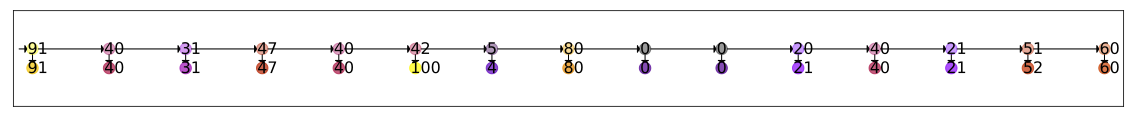

[ 0.  4.  8. 12. 16. 20. 24. 28. 32. 36. 40. 44. 48. 52. 56.]


In [150]:
# sample a random sequence within desired time peroiod from the above created model(for testing and generation)

# sample length (seconds)
sample_len = 60

# sample step (s)
sample_step = 4

# sample uniformly
t_seq = range(0,sample_len, sample_step)
t_seq, s_seq, e_seq = chmm.generate( len(t_seq), time=t_seq)

#resize plot
plt.rcParams['figure.figsize'] = [20,20]

hmms.plot_hmm( s_seq, e_seq, time=t_seq )
print(t_seq)

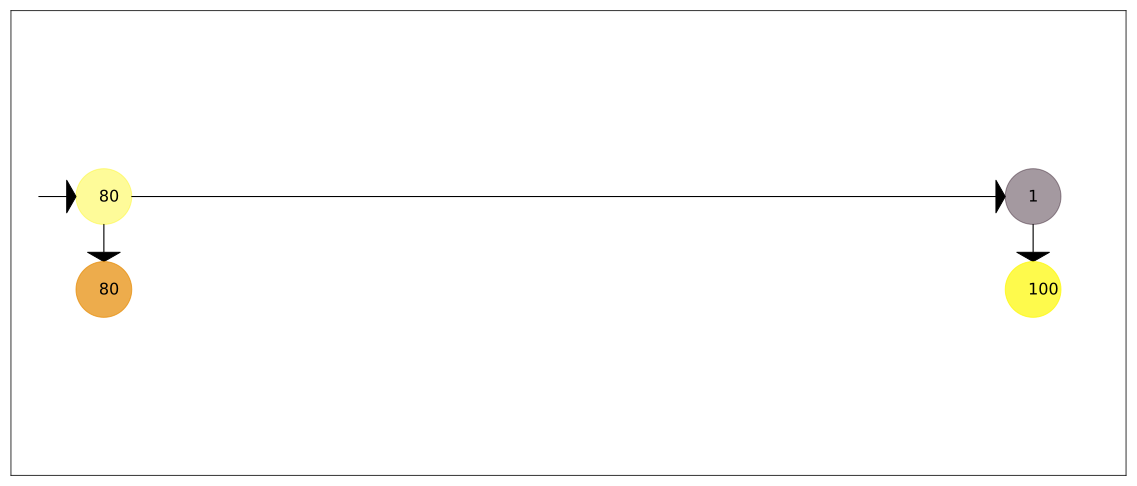

found state sequence: 
 [80  1]
predicted state looking 10.000000 seconds into the future: 1
Probability of being generated by the found state sequence: 1.3797343856885065e-05
state probs: 
 [0.01880108 0.01954304 0.01934584 0.01914859 0.0189513  0.01875396
 0.01855659 0.01835919 0.01816177 0.01796433 0.01776688 0.01756942
 0.01737196 0.0171745  0.01697705 0.01677962 0.0165822  0.01638482
 0.01618746 0.01599014 0.01579285 0.01559561 0.01539842 0.01520129
 0.0150042  0.01480718 0.01461021 0.01441331 0.01421648 0.01401972
 0.01382303 0.0136264  0.01342985 0.01323338 0.01303697 0.01284064
 0.01264439 0.0124482  0.01225209 0.01205604 0.01186007 0.01166416
 0.01146831 0.01127252 0.01107679 0.01088111 0.01068549 0.01048991
 0.01029438 0.01009888 0.00990342 0.009708   0.00951259 0.00931721
 0.00912185 0.0089265  0.00873116 0.00853582 0.00834048 0.00814513
 0.00794977 0.0077544  0.00755901 0.00736359 0.00716814 0.00697267
 0.00677715 0.0065816  0.006386   0.00619036 0.00599467 0.00579892
 0.00

In [152]:
# now let's try some prediction, define the predict function

def predict(obs=np.array([59,58]), predict_time=20.0, verbose=False):

    # observations so far (this is where we have seen people being in a place at a specific time):
    e_seq = np.array(obs)
    # assume the observations were made 1 second apart
    t_seq = np.array(range(0,len(e_seq)))

    # Now the predict step
    # the last observation codes for unknown, "abusing" the Viterbi algorithm to provide predictions 
    # purely on the transition model
    e_seq[-1:]=N_nodes 

    # this is the look ahead time (i.e. the time we look into the future based on the last observation)
    #predict_time = 1.2

    # set the last "unknown" observation time:
    t_seq[-1] = t_seq[-2] + predict_time

    #print(t_seq, e_seq)

    # run Viterbi algorithm for the CtHMM
    ( log_prob, s_seq ) =  chmm.viterbi( t_seq, e_seq )


    # We can also query the state distribution for the entire sequence
    log_prob_table = chmm.states_confidence( t_seq, e_seq )
    post_distribution = np.exp( log_prob_table[-1] )

    if verbose:
        # Let's print the most likely state sequence
        hmms.plot_hmm( s_seq, e_seq, time = t_seq )
        print( "found state sequence: \n", s_seq )
        print( "predicted state looking %f seconds into the future: %d" % (predict_time, s_seq[-1]) )
        print( "Probability of being generated by the found state sequence:", np.exp( log_prob ) )
        print( "state probs: \n", post_distribution)

    uniform = np.array([1.0 / N_nodes] * N_nodes)

    # KL divergence: https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Basic_example
    # D_KL = (post_distribution || uniform)
    # KL can be used here as a measure of certainty to some extend, used to compare against uniform distribution, 
    # the longer into the future the prediction, the closer KL is to 0
    D_KL = np.sum(np.multiply(post_distribution, np.log(np.divide(post_distribution, uniform))))
    
    if verbose:
        print("Kullback–Leibler divergence (high is good in this case, as I compare against uniform): %f" % D_KL)

    return (s_seq[-1], D_KL, post_distribution)
    #for i in range(0,len(uniform)):


(state, KL, posteriors) = predict(
    # start with some observations assumed to have made up to a point
    obs=np.array([80,20]),
    # the time horizon to predict to
    predict_time=10.0,
    # we want to see stuff here
    verbose=True
)


state predictions:
{1.0: 0,
 2.0: 1,
 3.0: 1,
 4.0: 1,
 5.0: 1,
 6.0: 1,
 7.0: 1,
 8.0: 1,
 9.0: 1,
 10.0: 1,
 11.0: 1,
 12.0: 1,
 13.0: 1,
 14.0: 1,
 15.0: 1,
 16.0: 1,
 17.0: 1,
 18.0: 1,
 19.0: 1,
 20.0: 1,
 21.0: 1,
 22.0: 1,
 23.0: 1,
 24.0: 1,
 25.0: 1,
 26.0: 1,
 27.0: 1,
 28.0: 1,
 29.0: 1,
 30.0: 1,
 31.0: 1,
 32.0: 1,
 33.0: 1,
 34.0: 1,
 35.0: 1,
 36.0: 1,
 37.0: 1,
 38.0: 1,
 39.0: 1,
 40.0: 1,
 41.0: 1,
 42.0: 1,
 43.0: 1,
 44.0: 1,
 45.0: 1,
 46.0: 1,
 47.0: 1,
 48.0: 1,
 49.0: 1,
 50.0: 1,
 51.0: 1,
 52.0: 1,
 53.0: 1,
 54.0: 1,
 55.0: 1,
 56.0: 1,
 57.0: 1,
 58.0: 1,
 59.0: 1,
 60.0: 1}


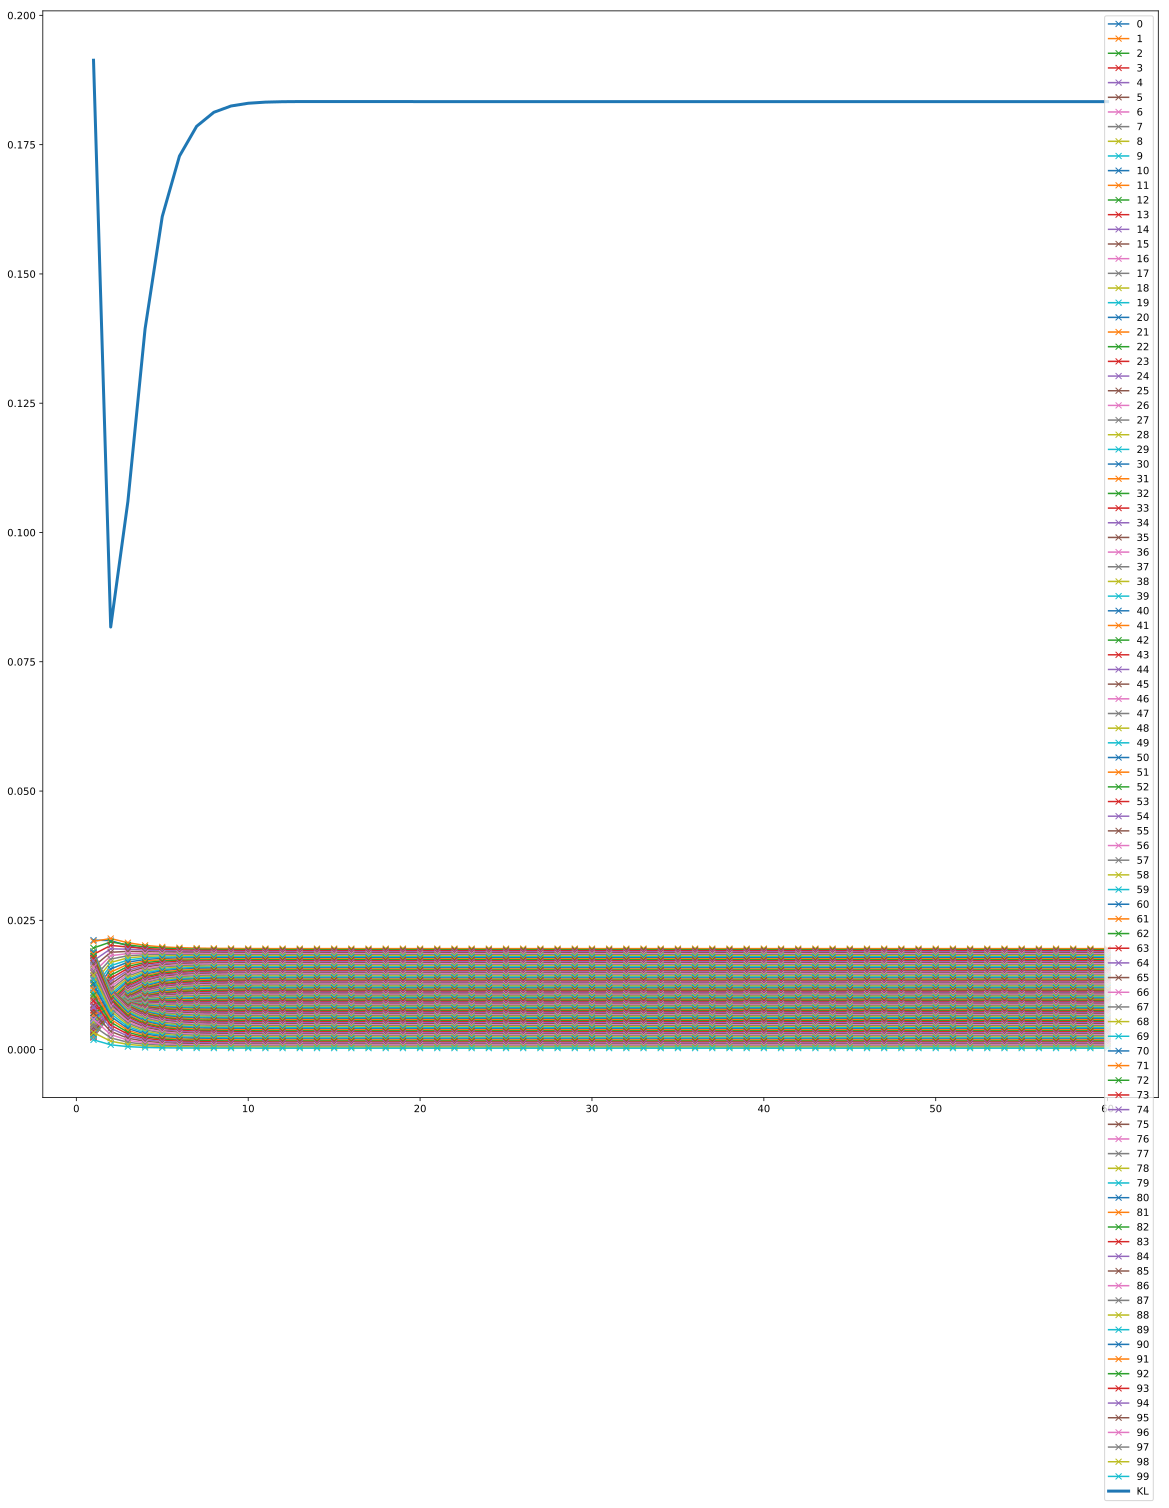

In [153]:
# now some iterations:

# forecast max seconds
forecast_max = 60
forecast_steps = 60

posteriors = []
states = {}
kls = []
times = []
bars = []

# try forecasting for several time steps:
for i in np.linspace(1, forecast_max, forecast_steps):  # Return evenly spaced numbers over a specified interval (start,stop, Num = int).
    (state, kl, posterior) = predict(
        obs = [80,20],
        predict_time = i,
        verbose = False
    )
    times.append(i)
    posteriors.append(posterior)
    states[i] = state
    kls.append(kl)

# plot the posterior probabilities
plt.plot(times, posteriors, '-x')

# plot the KL divergence (certainty)
plt.plot(times, kls, linewidth=3)

legend = list(range(0, N_nodes))
legend.append('KL')
plt.legend(legend)
print('state predictions:\n%s' % pformat(states))